In [1]:
# Project2
# Mohammad KordMafi _ AmirHossein Mahmoodnia

#1 import necessary modules
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import skfuzzy.control as ctrl
from rasterio.enums import Resampling
from skimage.transform import resize

In [2]:
#2 Define file paths for the GDB and raster layers

gdb_path = r"E:\master\sc\projects\2\Q3\HW01.gdb"
districts_layer = "Districts"
dist2river_path = r'E:\master\sc\projects\2\dist2river.tif'
precip_path = r'E:\master\sc\projects\2\precip.tif'

# Read the districts layer from the GDB
districts_data = gpd.read_file(gdb_path, layer=districts_layer)

# Read the raster layers
with rasterio.open(dist2river_path) as dist2river:
    dist2river_data = dist2river.read(1)

with rasterio.open(precip_path) as precip:
    precip_data = precip.read(1)

# Print CRS information for the layers
print(f"CRS of districts_data: {districts_data.crs}")

with rasterio.open(dist2river_path) as dist2river:
    print(f"CRS of dist2river: {dist2river.crs}")

with rasterio.open(precip_path) as precip:
    print(f"CRS of precip: {precip.crs}")


CRS of districts_data: EPSG:32639
CRS of dist2river: PROJCS["Lambert Conformal Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",24],PARAMETER["central_meridian",54],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
CRS of precip: PROJCS["South_Pole_Lambert_Azimuthal_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitu

In [3]:
#3 Clip Layers Before CRS Alignment (with Error)
district_id = '22'
district = districts_data[districts_data['IDMAN'] == district_id]

# Open the dist2river raster file for reading
with rasterio.open(dist2river_path) as dist2river:
    
    dist2river_geom = district.geometry.iloc[0]  
    dist2river_masked, dist2river_transform = mask(dist2river, [dist2river_geom], crop=True)
    print(f"Dist2River clipped shape: {dist2river_masked.shape}")

# Open the precip raster file for reading
with rasterio.open(precip_path) as precip:
    
    precip_geom = district.geometry.iloc[0]  
    precip_masked, precip_transform = mask(precip, [precip_geom], crop=True)
    print(f"Precip clipped shape: {precip_masked.shape}")

ValueError: Input shapes do not overlap raster.

In [4]:
#4 Reproject Raster Layers to Target CRS

from rasterio.warp import calculate_default_transform, reproject, Resampling
target_crs = districts_data.crs

# Reproject raster layers to the target CRS of districts
def reproject_raster(input_raster_path, output_raster_path, target_crs):
    with rasterio.open(input_raster_path) as src:
        
        transform, width, height = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)

        # Write reprojected data to output file with the new CRS
        with rasterio.open(output_raster_path, 'w', driver='GTiff', 
                           count=src.count, dtype=src.dtypes[0], crs=target_crs, 
                           transform=transform, width=width, height=height) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest)

# Reproject dist2river and precip rasters
reproject_raster(dist2river_path, r'E:\master\sc\projects\2\dist2river_reprojected.tif', target_crs)
reproject_raster(precip_path, r'E:\master\sc\projects\2\precip_reprojected.tif', target_crs)

# Print CRS of districts and confirm CRS update for rasters
print(f"CRS of districts_data: {districts_data.crs}")
print("CRS of rasters has been updated to match districts CRS.")

# Report CRS of reprojected dist2river and precip
with rasterio.open(r'E:\master\sc\projects\2\dist2river_reprojected.tif') as dist2river_reprojected:
    print(f"CRS of updated dist2river: {dist2river_reprojected.crs}")
with rasterio.open(r'E:\master\sc\projects\2\precip_reprojected.tif') as precip_reprojected:
    print(f"CRS of updated precip: {precip_reprojected.crs}")



CRS of districts_data: EPSG:32639
CRS of rasters has been updated to match districts CRS.
CRS of updated dist2river: EPSG:32639
CRS of updated precip: EPSG:32639


Dist2River clipped shape: (1, 31, 74)
Precip clipped shape: (1, 30, 74)


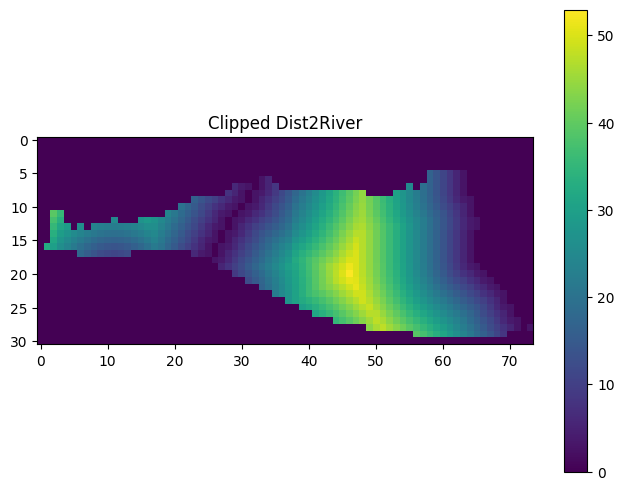

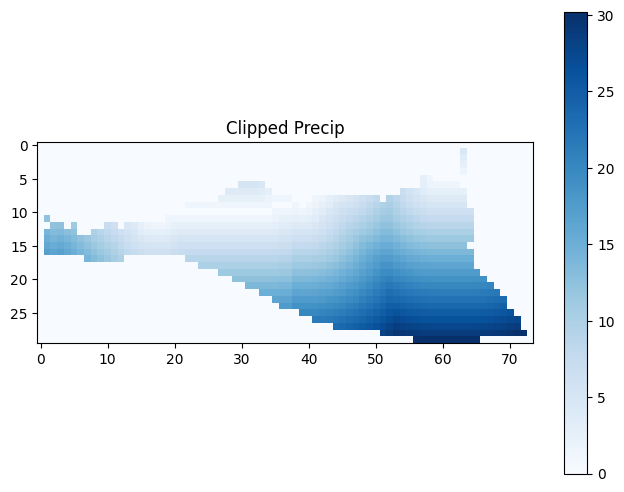

In [5]:
#5 Clip and Visualize Raster Layers for Selected District

# Select the Tehran district with the specified IDMAN
district_id = '22'
district = districts_data[districts_data['IDMAN'] == district_id]

# Get the geometry of the selected district
district_geom = district.geometry.iloc[0]

# Clip the dist2river raster layer using the district geometry
with rasterio.open(r'E:\master\sc\projects\2\dist2river_reprojected.tif') as dist2river:
    dist2river_masked, dist2river_transform = mask(dist2river, [district_geom], crop=True)
    print(f"Dist2River clipped shape: {dist2river_masked.shape}")

# Clip the precip raster layer using the district geometry
with rasterio.open(r'E:\master\sc\projects\2\precip_reprojected.tif') as precip:
    precip_masked, precip_transform = mask(precip, [district_geom], crop=True)
    print(f"Precip clipped shape: {precip_masked.shape}")

# Display the clipped dist2river layer
plt.figure(figsize=(8, 6))
plt.imshow(dist2river_masked[0], cmap='viridis')  # Displaying the first band
plt.colorbar()
plt.title("Clipped Dist2River")
plt.show()

# Display the clipped precip layer
plt.figure(figsize=(8, 6))
plt.imshow(precip_masked[0], cmap='Blues')  # Displaying the first band
plt.colorbar()
plt.title("Clipped Precip")
plt.show()

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


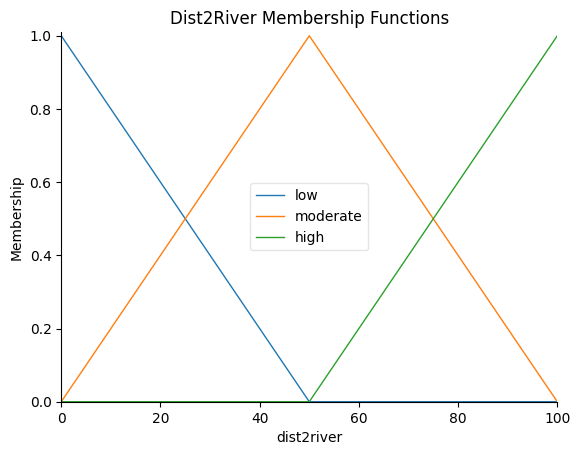

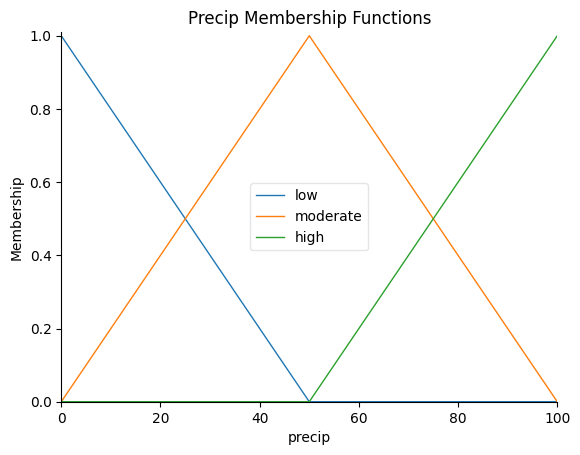

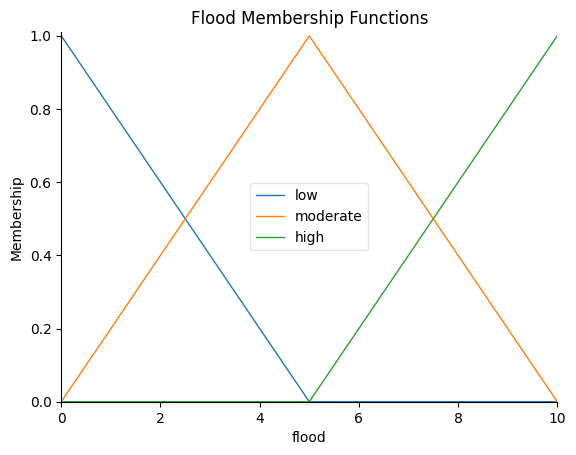

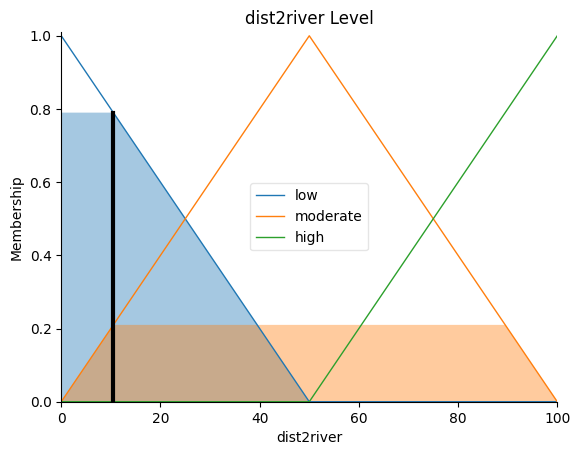

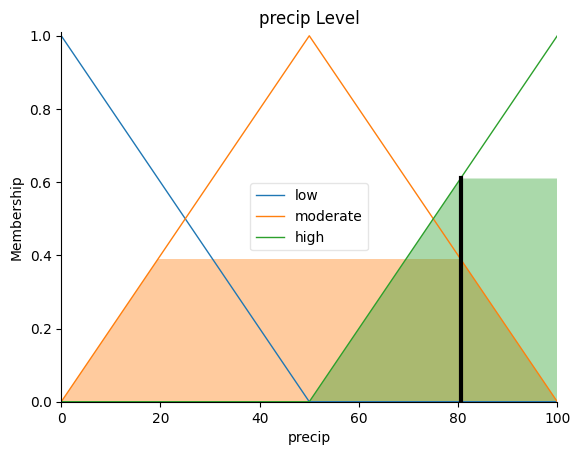

Flood Risk: 8.15095923261391


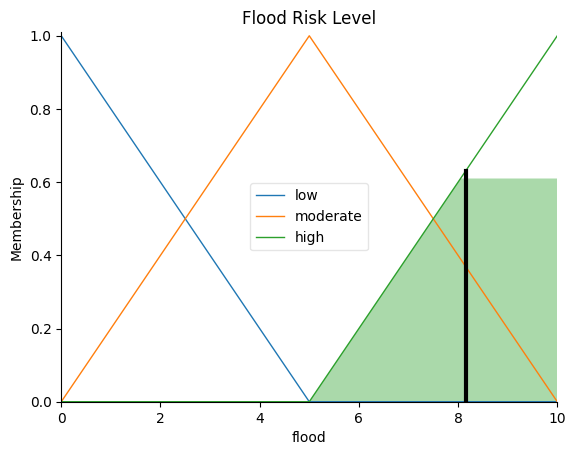

In [62]:
#6 Fuzzy Inference System for Flood Risk Assessment

# 'dist2river' and 'precip' are antecedents (inputs)
dist2river = ctrl.Antecedent(np.arange(0, 101, 1), 'dist2river')
precip = ctrl.Antecedent(np.arange(0, 101, 1), 'precip')

# 'flood' is the consequent (output)
flood = ctrl.Consequent(np.arange(0, 11, 1), 'flood')

# 2. Define membership functions for 'dist2river'
dist2river['low'] = fuzz.trimf(dist2river.universe, [0, 0, 50])
dist2river['moderate'] = fuzz.trimf(dist2river.universe, [0, 50, 100])
dist2river['high'] = fuzz.trimf(dist2river.universe, [50, 100, 100])

# 3. Define membership functions for 'precip'
precip['low'] = fuzz.trimf(precip.universe, [0, 0, 50])
precip['moderate'] = fuzz.trimf(precip.universe, [0, 50, 100])
precip['high'] = fuzz.trimf(precip.universe, [50, 100, 100])

# 4. Define membership functions for 'flood'
flood['low'] = fuzz.trimf(flood.universe, [0, 0, 5])
flood['moderate'] = fuzz.trimf(flood.universe, [0, 5, 10])
flood['high'] = fuzz.trimf(flood.universe, [5, 10, 10])

# 5. Visualize the membership functions
# For dist2river
dist2river.view()
plt.title('Dist2River Membership Functions')
plt.show()

# For precip
precip.view()
plt.title('Precip Membership Functions')
plt.show()

# For flood
flood.view()
plt.title('Flood Membership Functions')
plt.show()

# 6. Define fuzzy rules
# These rules determine how the inputs (dist2river, precip) affect the output (flood)
rule1 = ctrl.Rule(dist2river['low'] & precip['high'], flood['high'])
rule2 = ctrl.Rule(dist2river['low'] & precip['moderate'], flood['high'])
rule3 = ctrl.Rule(dist2river['moderate'] & precip['low'], flood['moderate'])
rule4 = ctrl.Rule(dist2river['high'] & precip['high'], flood['moderate'])
rule5 = ctrl.Rule(dist2river['high'] & precip['low'], flood['low'])
rule6 = ctrl.Rule(dist2river['moderate'] & precip['high'], flood['high'])

# 7. Create control system and simulation
flood_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
flood_sim = ctrl.ControlSystemSimulation(flood_ctrl)

# 8. Example of running the simulation with specific inputs
flood_sim.input['dist2river'] = 10.5  
flood_sim.input['precip'] = 80.5      

# Compute the output (flood risk)
flood_sim.compute()

# Show the output (flood risk level) membership function
dist2river.view(sim=flood_sim)
plt.title('dist2river Level')
plt.show()
precip.view(sim=flood_sim)
plt.title('precip Level')
plt.show()

# Print the output (flood risk level)
print(f"Flood Risk: {flood_sim.output['flood']}")
flood.view(sim=flood_sim)
plt.title('Flood Risk Level')
plt.show()



Dist2River clipped shape: (1, 31, 74)
Precip clipped shape: (1, 30, 74)


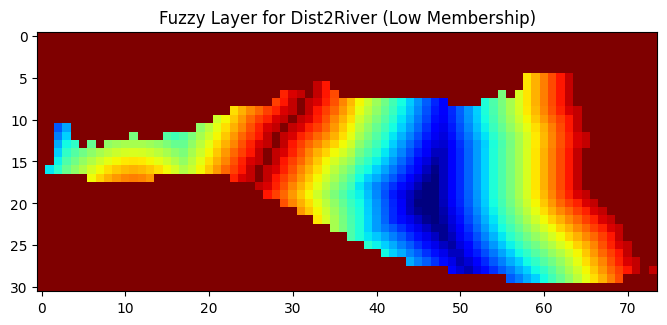

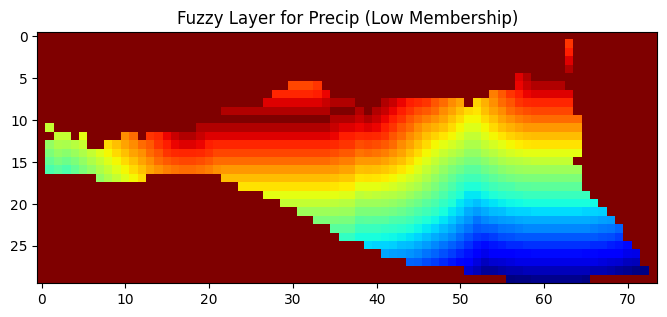

TIFF images have been saved.


In [63]:
#7 Display and Save Fuzzified Layers
district_id = '22'
district = districts_data[districts_data['IDMAN'] == district_id]

# Get the geometry of the selected district
district_geom = district.geometry.iloc[0]

# Clip the dist2river raster layer using the district geometry
with rasterio.open(r'E:\master\sc\projects\2\dist2river_reprojected.tif') as dist2river:
    dist2river_masked, dist2river_transform = mask(dist2river, [district_geom], crop=True)
    print(f"Dist2River clipped shape: {dist2river_masked.shape}")

# Clip the precip raster layer using the district geometry
with rasterio.open(r'E:\master\sc\projects\2\precip_reprojected.tif') as precip:
    precip_masked, precip_transform = mask(precip, [district_geom], crop=True)
    print(f"Precip clipped shape: {precip_masked.shape}")

# 1. Define fuzzy sets manually (as they were before)
dist2river_universe = np.arange(0, 101, 1)  # Define universe for dist2river
precip_universe = np.arange(0, 101, 1)  # Define universe for precip

# Fuzzy sets for dist2river
dist2river_low = fuzz.trimf(dist2river_universe, [0, 0, 50])
dist2river_moderate = fuzz.trimf(dist2river_universe, [0, 50, 100])
dist2river_high = fuzz.trimf(dist2river_universe, [50, 100, 100])

# Fuzzy sets for precip
precip_low = fuzz.trimf(precip_universe, [0, 0, 50])
precip_moderate = fuzz.trimf(precip_universe, [0, 50, 100])
precip_high = fuzz.trimf(precip_universe, [50, 100, 100])

# Create fuzzy sets list
dist2river_sets = [dist2river_low, dist2river_moderate, dist2river_high]
precip_sets = [precip_low, precip_moderate, precip_high]

# 2. Fuzzify the clipped dist2river and precip rasters
def fuzzify_layer(layer, fuzzy_sets, universe):
    fuzzy_layer = np.zeros((layer.shape[0], layer.shape[1], len(fuzzy_sets)))
    
    for i in range(layer.shape[0]):
        for j in range(layer.shape[1]):
            value = layer[i, j]
            if np.isnan(value):
                continue
            # Use the fuzzy_sets directly and calculate membership for each set
            for k, fuzzy_set in enumerate(fuzzy_sets):
                fuzzy_layer[i, j, k] = fuzz.interp_membership(universe, fuzzy_set, value)
    
    return fuzzy_layer

# Fuzzify the clipped rasters
fuzzy_dist2river = fuzzify_layer(dist2river_masked[0], dist2river_sets, dist2river_universe)
fuzzy_precip = fuzzify_layer(precip_masked[0], precip_sets, precip_universe)

# 3. Display the fuzzy layers for dist2river and precip on maps
# Normalize the fuzzy values to [0, 255] for displaying as images
fuzzy_dist2river_normalized = np.uint8(fuzzy_dist2river * 255)
fuzzy_precip_normalized = np.uint8(fuzzy_precip * 255)

# Display the fuzzy layer for dist2river (low membership)
plt.figure(figsize=(8, 6))
plt.imshow(fuzzy_dist2river_normalized[..., 0], cmap='jet')  # Displaying 'low' membership for dist2river
plt.title("Fuzzy Layer for Dist2River (Low Membership)")
plt.show()

# Display the fuzzy layer for precip (low membership)
plt.figure(figsize=(8, 6))
plt.imshow(fuzzy_precip_normalized[..., 0], cmap='jet')  # Displaying 'low' membership for precip
plt.title("Fuzzy Layer for Precip (Low Membership)")
plt.show()

# 4. Save the fuzzy layers as TIFF images with metadata
with rasterio.open(r'E:\master\sc\projects\2\dist2river_reprojected.tif') as dist2river:
    dist2river_meta = dist2river.meta.copy()

# Save fuzzy dist2river layer as TIFF
with rasterio.open('fuzzy_dist2river_low.tiff', 'w', **dist2river_meta) as dst:
    dst.write(fuzzy_dist2river_normalized[..., 0], 1)  # Write the 'low' membership to the first band

# Save fuzzy precip layer as TIFF
with rasterio.open('fuzzy_precip_low.tiff', 'w', **dist2river_meta) as dst:
    dst.write(fuzzy_precip_normalized[..., 0], 1)  # Write the 'low' membership to the first band

print("TIFF images have been saved.")


Flood layer for district 22 saved to E:\master\sc\projects\2\flood_output_district_22.tif


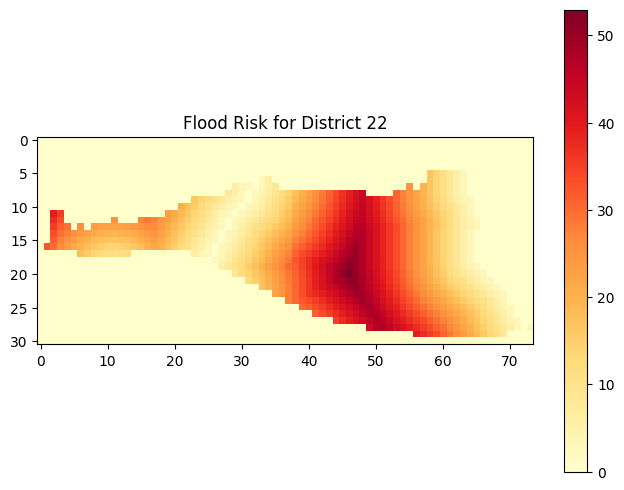

In [64]:
#8 Generate and Save Flood Risk Layer for District 22

# Create flood risk layer for each pixel
output_flood = np.zeros_like(dist2river_masked[0], dtype=np.float32)

# Resize precip_masked to match dist2river_masked size
precip_resized = resize(precip_masked[0], dist2river_masked[0].shape[1:], preserve_range=True)

# Apply fuzzy system to each pixel of dist2river and precip layers
for i in range(output_flood.shape[0]):
    for j in range(output_flood.shape[1]):
        dist2river_value = dist2river_masked[0][i, j]
        precip_value = precip_resized[i, j] 

        # Ensure input values are within the range of membership functions
        if dist2river_value < 0:
            dist2river_value = 0
        elif dist2river_value > 100:
            dist2river_value = 100

        if precip_value < 0:
            precip_value = 0
        elif precip_value > 100:
            precip_value = 100

        # Apply inputs to fuzzy system
        flood_sim.input['dist2river'] = dist2river_value
        flood_sim.input['precip'] = precip_value

        # Compute the fuzzy output (flood risk)
        flood_sim.compute()

        # Store the result in the flood layer
        if 'flood' in flood_sim.output:
            output_flood[i, j] = flood_sim.output['flood']
        else:
            # Default value if no output
            output_flood[i, j] = 0

# Select the district by IDMAN and get its geometry for clipping
district_id = '22'
district = districts_data[districts_data['IDMAN'] == district_id]
district_geom = district.geometry.iloc[0]

# Use metadata from dist2river layer to save the flood layer
with rasterio.open(r'E:\master\sc\projects\2\dist2river_reprojected.tif') as src:
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height

    # Clip the flood layer to the selected district
    output_flood_clipped, transform_clipped = mask(src, [district_geom], crop=True)

    # Adjust dimensions of the clipped flood layer
    output_flood_clipped = output_flood_clipped[0]  # Select only the first band

    # Save the clipped flood layer as a GeoTIFF
    output_flood_path = r'E:\master\sc\projects\2\flood_output_district_22.tif'
    with rasterio.open(output_flood_path, 'w', driver='GTiff', count=1, dtype='float32', crs=crs,
                       transform=transform_clipped, width=output_flood_clipped.shape[1], height=output_flood_clipped.shape[0]) as dst:
        dst.write(output_flood_clipped, 1)

    print(f"Flood layer for district 22 saved to {output_flood_path}")

# Load and display the saved flood layer
with rasterio.open(output_flood_path) as flood_layer:
    flood_data = flood_layer.read(1)

# Display the flood risk for District 22
plt.figure(figsize=(8, 6))
plt.imshow(flood_data, cmap='YlOrRd')  
plt.colorbar()
plt.title("Flood Risk for District 22")
plt.show()